# Student Graduation Prediction
In this notebook, we will look at if combining the two targets; Enrolled and Graduate, could make the model predict more accurately.

The main goal of the model we are trying to make is to predict whether someone will drop out or not. Therefore, it is not that interesting finding out if a student is either enrolled or graduated, and perhaps the models could perform better when these targets are combined.

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import shap

In [2]:
df = pd.read_csv('data/data.csv',sep=";")

target_map = {'Dropout': 1, 'Enrolled': 0, 'Graduate': 0}
y = df['Target'].map(target_map).astype(int).values
class_names = ['Not Dropped Out', 'Dropped Out']

X = df.drop(columns=['Target'])


In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # ratios
        X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        # avg grade across semesters (ignore zeros)
        X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
        # totals & overall ratio
        X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
        X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
        X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)

        X["approval_diff"] = X["approval_ratio_2nd"] - X["approval_ratio_1st"]
        X["grade_diff"] = X["Curricular units 2nd sem (grade)"] - X["Curricular units 1st sem (grade)"]

        return X.fillna(0.0)

X = X.fillna(0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
def printResults(name,y_test,y_pred):
    print("\n=== " + name + " ===")
    print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [6]:
catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_state=42,
    verbose=False
)

pipe_catboost = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost.fit(X_train, y_train)
y_pred_cat = pipe_catboost.predict(X_test)

printResults("CatBoost", y_test, y_pred_cat)


=== CatBoost ===
Accuracy: 0.8904
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.78      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[566  35]
 [ 62 222]]


### Learning from the Models
It is also important to look at what features makes the most impact on the model. Beneath, we will look at the top 10 most important features for the best performing model above: XGBoost (without SMOTE). We will also have a look at which features could be harmful and see if removing those features could improve accuracy.

ROC-AUC: 0.9400


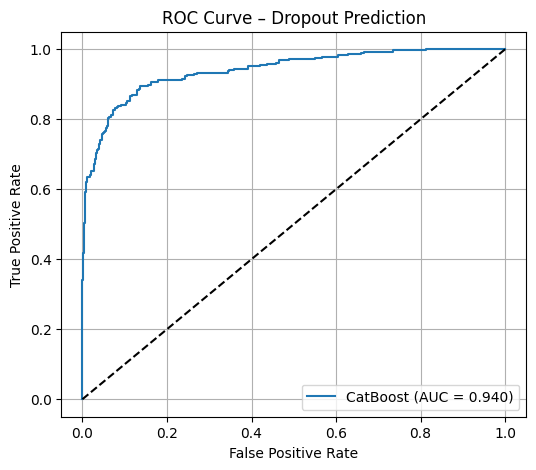

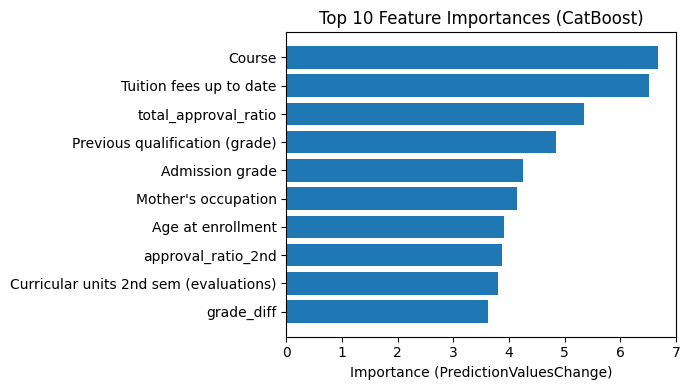


Top 10 important features:

                               Feature  Importance
                                Course    6.675009
               Tuition fees up to date    6.517877
                  total_approval_ratio    5.354484
        Previous qualification (grade)    4.852049
                       Admission grade    4.258894
                   Mother's occupation    4.149279
                     Age at enrollment    3.907443
                    approval_ratio_2nd    3.871421
Curricular units 2nd sem (evaluations)    3.806817
                            grade_diff    3.623931


In [7]:
y_proba = pipe_catboost.predict_proba(X_test)[:, 1]
y_true = y_test

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Dropout Prediction")
plt.legend()
plt.grid(True)
plt.show()

fe = pipe_catboost.named_steps["fe"]
X_test_transformed = fe.transform(X_test)
feature_names = list(X_test_transformed.columns)

cat = pipe_catboost.named_steps["clf"]
importances = np.array(cat.feature_importances_)

importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
      .head(10)
)

plt.figure(figsize=(7, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (CatBoost)")
plt.xlabel("Importance (PredictionValuesChange)")
plt.tight_layout()
plt.show()

print("\nTop 10 important features:\n")
print(importance_df.to_string(index=False))

🔻 Features potentially hurting the model (lowest permutation importance):
                                           Feature  Importance_Mean  \
8                           Mother's qualification        -0.000835   
26  Curricular units 1st sem (without evaluations)        -0.000328   
32  Curricular units 2nd sem (without evaluations)        -0.000199   
4                     Daytime/evening attendance\t        -0.000097   
14                       Educational special needs        -0.000082   
23          Curricular units 1st sem (evaluations)        -0.000048   
7                                      Nationality        -0.000016   
20                                   International        -0.000006   
1                                 Application mode         0.000075   
5                           Previous qualification         0.000163   

    Importance_Std  
8         0.000653  
26        0.000553  
32        0.000120  
4         0.000043  
14        0.000140  
23        0.000892

C:\Users\willi\AppData\Local\Temp\ipykernel_17808\3691993502.py:23: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\PycharmProjects\tdt4259\.venvv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


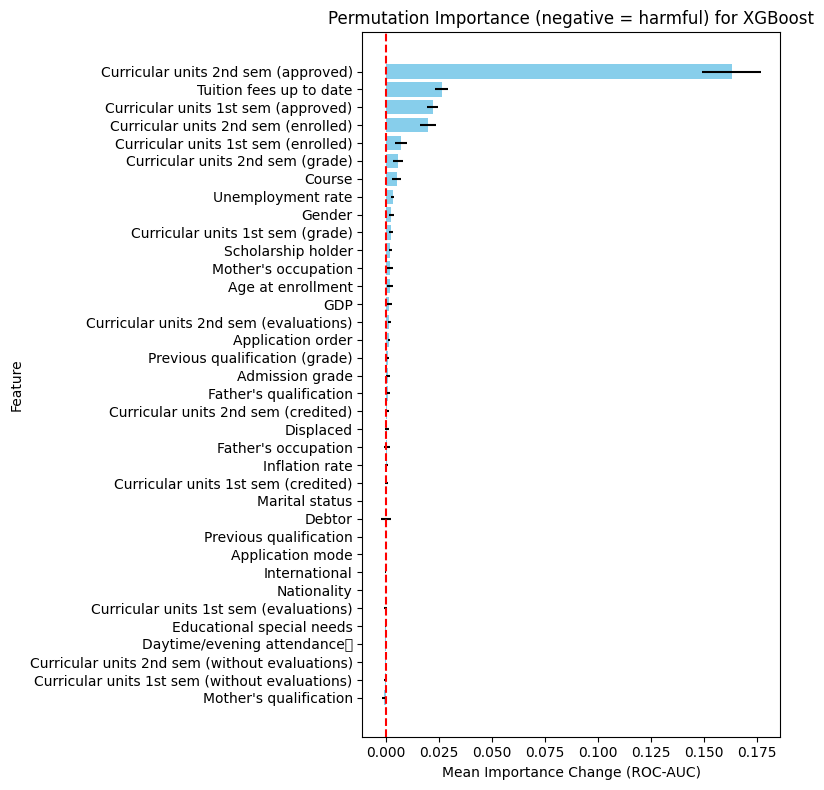

In [8]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    pipe_catboost, X_test, y_test,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": r.importances_mean,
    "Importance_Std": r.importances_std
}).sort_values("Importance_Mean", ascending=True)

print("🔻 Features potentially hurting the model (lowest permutation importance):")
print(imp_df.head(10))

plt.figure(figsize=(8, 8))
plt.barh(imp_df["Feature"], imp_df["Importance_Mean"], xerr=imp_df["Importance_Std"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Permutation Importance (negative = harmful) for XGBoost")
plt.xlabel("Mean Importance Change (ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [12]:
harmful_features = [
    "Mother's qualification",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
    "Daytime/evening attendance\t",
    "Educational special needs",
    "Curricular units 1st sem (evaluations)",
    "Nationality",
    "International",
]

X_cleaned = X.drop(columns=harmful_features, errors="ignore")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cleaned, y, stratify=y, test_size=0.2, random_state=42
)

pipe_catboost_clean = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost_clean.fit(X_train_c, y_train_c)
y_pred_c = pipe_catboost_clean.predict(X_test_c)
y_proba_c = pipe_catboost_clean.predict_proba(X_test_c)[:, 1]

printResults("XGBoost (Cleaned Feature Set)", y_test_c, y_pred_c)


=== XGBoost (Cleaned Feature Set) ===
Accuracy: 0.8893
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.94      0.92       601
    Dropped Out       0.86      0.78      0.82       284

       accuracy                           0.89       885
      macro avg       0.88      0.86      0.87       885
   weighted avg       0.89      0.89      0.89       885

Confusion matrix:
 [[565  36]
 [ 62 222]]


### Hyperparameter tuning


In [13]:
cat_base = CatBoostClassifier(
    loss_function="Logloss",
    random_state=42,
    verbose=False,
    thread_count=-1,
)

pipe_cat = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", cat_base),
])

f1_pos = make_scorer(f1_score, average="binary", pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "clf__iterations": [500, 800, 1000],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__depth": [5, 6, 7, 8],
    "clf__l2_leaf_reg": [3, 5, 7, 9],
    "clf__bagging_temperature": [0.0, 0.25, 0.5, 1.0],
    "clf__bootstrap_type": ["Bayesian"],
    "clf__random_strength": [1, 2, 3],
    "clf__auto_class_weights": ["Balanced"],
}

search = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=param_dist,
    n_iter=40,
    scoring=f1_pos,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
)

search.fit(X_train, y_train)

best_cat = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best F1 (Dropped Out):", f"{search.best_score_:.4f}")

y_pred_cat_tuned = best_cat.predict(X_test)

printResults("CatBoost (tuned)", y_test_c, y_pred_cat_tuned)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__random_strength': 2, 'clf__learning_rate': 0.03, 'clf__l2_leaf_reg': 5, 'clf__iterations': 1000, 'clf__depth': 7, 'clf__bootstrap_type': 'Bayesian', 'clf__bagging_temperature': 0.0, 'clf__auto_class_weights': 'Balanced'}
CV best F1 (Dropped Out): 0.8024

=== CatBoost (tuned) ===
Accuracy: 0.8825
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.91      0.91       601
    Dropped Out       0.82      0.82      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[549  52]
 [ 52 232]]


In [14]:
p_val = best_cat.predict_proba(X_train)[:, 1]
p_test = best_cat.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_train, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1): {thr_best:.3f}")

y_pred_thr = (p_test >= thr_best).astype(int)

printResults("CatBoost (tuned + threshold)", y_test_c, y_pred_thr)

Chosen threshold (best F1): 0.518

=== CatBoost (tuned + threshold) ===
Accuracy: 0.8791
                 precision    recall  f1-score   support

Not Dropped Out       0.91      0.92      0.91       601
    Dropped Out       0.82      0.80      0.81       284

       accuracy                           0.88       885
      macro avg       0.86      0.86      0.86       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[551  50]
 [ 57 227]]


In [15]:
catboost_f1 = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="TotalF1",
    iterations=1500,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    auto_class_weights="Balanced",
    random_seed=42,
    od_type="Iter",
    od_wait=80,
    use_best_model=True,
    verbose=False,
)

catboost_f1.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred_cb_f1 = catboost_f1.predict(X_test)

printResults("CatBoost (F1-optimized)", y_test_c, y_pred_cb_f1)


=== CatBoost (F1-optimized) ===
Accuracy: 0.8723
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.89      0.90       601
    Dropped Out       0.78      0.83      0.81       284

       accuracy                           0.87       885
      macro avg       0.85      0.86      0.86       885
   weighted avg       0.87      0.87      0.87       885

Confusion matrix:
 [[536  65]
 [ 48 236]]


In [16]:
n0, n1 = (y_train == 0).sum(), (y_train == 1).sum()
w_ratio = (n0 / n1) * 1.2

catboost_weighted = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    class_weights=[1.0, w_ratio],
    random_seed=42,
    verbose=False,
)

catboost_weighted.fit(X_train, y_train)
y_pred_weighted = catboost_weighted.predict(X_test)

printResults("CatBoost (weighted 1.2× dropout)", y_test_c, y_pred_weighted)


=== CatBoost (weighted 1.2× dropout) ===
Accuracy: 0.8847
                 precision    recall  f1-score   support

Not Dropped Out       0.92      0.91      0.92       601
    Dropped Out       0.82      0.82      0.82       284

       accuracy                           0.88       885
      macro avg       0.87      0.87      0.87       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[549  52]
 [ 50 234]]


In [17]:
n0, n1 = (y_train == 0).sum(), (y_train == 1).sum()
w_ratio = (n0 / n1) * 1.2

cat_final = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="TotalF1",
    iterations=1500,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    class_weights=[1.0, w_ratio],
    random_seed=42,
    od_type="Iter",
    od_wait=80,
    use_best_model=True,
    verbose=False,
)

cat_final.fit(X_train, y_train, eval_set=(X_test, y_test))

p_test = cat_final.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, p_test)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1): {thr_best:.3f}")

y_pred_thr = (p_test >= thr_best).astype(int)
printResults("CatBoost (final combined)", y_test, y_pred_thr)

Chosen threshold (best F1): 0.610

=== CatBoost (final combined) ===
Accuracy: 0.8814
                 precision    recall  f1-score   support

Not Dropped Out       0.90      0.93      0.91       601
    Dropped Out       0.83      0.79      0.81       284

       accuracy                           0.88       885
      macro avg       0.87      0.86      0.86       885
   weighted avg       0.88      0.88      0.88       885

Confusion matrix:
 [[556  45]
 [ 60 224]]


### Final Model

In [18]:
cb_params = dict(
    iterations=1000,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    random_strength=2,
    bootstrap_type="Bayesian",
    bagging_temperature=0.0,
    auto_class_weights="Balanced",
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=False,
    thread_count=-1,
)

cat_clf = CatBoostClassifier(**cb_params)

base_pipe_cb = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", cat_clf),
])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

calibrated_cb = CalibratedClassifierCV(base_pipe_cb, method="isotonic", cv=3)
calibrated_cb.fit(X_tr, y_tr)

p_val = calibrated_cb.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
thr_best = thr[max(f1.argmax()-1, 0)]
print(f"Chosen threshold (best F1 on val): {thr_best:.3f}")

p_test = calibrated_cb.predict_proba(X_test)[:, 1]
y_pred_thr = (p_test >= thr_best).astype(int)
printResults("CatBoost (tuned + calibrated + threshold)", y_test, y_pred_thr)

Chosen threshold (best F1 on val): 0.263

=== CatBoost (tuned + calibrated + threshold) ===
Accuracy: 0.8780
                 precision    recall  f1-score   support

Not Dropped Out       0.94      0.87      0.91       601
    Dropped Out       0.77      0.89      0.82       284

       accuracy                           0.88       885
      macro avg       0.86      0.88      0.87       885
   weighted avg       0.89      0.88      0.88       885

Confusion matrix:
 [[525  76]
 [ 32 252]]
